# Food Preference Recommender on WWEIA dataset

## Background

### Traditional methods

Traditional food recommenders use content-based and collaborative techniques. But effectiveness of these approaches relies on having detailed information about users’ feelings, specifically the user for whom the recommendation is made and similar users, toward many different items. Such detailed information is difficult to obtain. Additionally, approaches either use data scraped from recipe rating websites or present users with a series of recipes and ask for their rating. This data is likely not fully representative of users’ eating patterns, as most users do not input ratings for all foods they eat. They probably only review foods they feel especially strongly (positively or negatively) about. Additionally, many of these methods do not consider the frequency with which a user eats a dish. This is important information that influences how likely a user would be to eat a recommended dish.

### Innovative methods

In addition to CB- and CF-based methods, others have taken innovative approaches to gauge food preferences in their recommender systems. [Ueda et al.](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.369.4380&rep=rep1&type=pdf) use a user’s food log to gauge how much users like various recipe ingredients based on their frequency of use. [Another group](https://pubmed.ncbi.nlm.nih.gov/30464375/) successively presents images to a user, using a convolutional neural network (CNN) algorithm to learn a user’s preferences. While the approach is innovative and interesting, it is unclear whether people base eating decisions on food appearance when preparing meals at home (instead of ordering in a restaurant). [Toledo et al.](https://www.semanticscholar.org/paper/A-Food-Recommender-System-Considering-Nutritional-Toledo-Alzahrani/160612b921627becdcc006e5256aacebc68612d1) integrate food preferences into their recommendation approach by devising menus containing ingredients that users have liked in the past but not eaten recently and revising based on user feedback of which ingredients they like and do not like. Other studies treat food recommendations as a query over a knowledge graph. [Chen et. al.](https://arxiv.org/abs/2101.01775) takes in a food log or list of liked foods and allergies and outputs recipes that are most similar to the input. [Park et. al.](https://www.nature.com/articles/s41598-020-79422-8) outputs sets of foods that are predicted to pair well together. However, these predictions do not take in user input.

### Difficulty in food data logging

Food logs have been used for purposes such as allergy detection and weight and disease management. One common difficulty has been consistently recording entries for a variety of reasons, such as the laboriousness involved in recording certain kinds of foods, negative emotions arising when journaling and lack of social support. Recent food logging applications such as MyFitnessPal, Cronometer and Lose It! have addressed these challenges by providing a platform that allows the user to input the food name, the quantity, the type of meal, and the time at which the user consumed the food. There can be gamification features or social support to address the barriers to journaling mentioned earlier. However, there are several shortcomings in using the food logs exported directly from these food logging apps. Food names can contain specific brand names, and the food log structure can differ from one website to another, making them difficult to streamline data processing and information retrieval.

## Problem Statement

Identify user’s most frequently-eaten foods. The assumption is that foods that are eaten most frequently are the preferred ones by the user. This information regarding user’s favored foods can be used to generate healthy and realistic meal recommendations that feature ingredients that the user commonly consumes.

## Approach

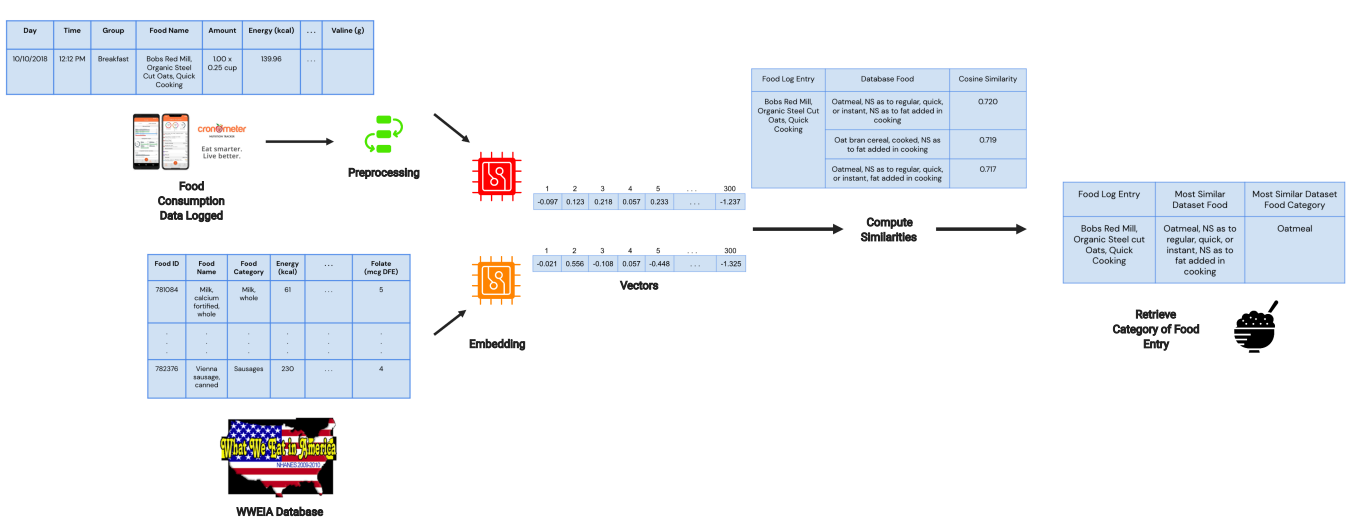

Workflow of the food preference learning algorithm. Each entry of the food log is processed through an NLP module. Then food embeddings is obtained for each food entry in the food log and the the database. Next, for each food embedding of the food log, Cosine similarity is run against all embeddings of the foods in the WWEIA database. The food category label of the food with the highest Cosine similarity is assigned to the food log entry. This process is repeated for all foods in the food logs. The most common food categories are then calculated.

As the correct labeling of a food depends on the similarity between a food log entry and its database counterpart (or the one most closely analogous). Thus to improve food label accuracy, food log entry names were preprocessed in various ways to remove words that increased similarity to incorrect FNDDS entries or decreased similarity to the correct entry.

- Method 1 - only retain the food’s general name.
- Method 2 - similar to method 1, but retained the comma-separated phrases that contained specific details.
- Method 3 - like Method 2, retained most of the food name, but used another heuristic to judge whether the first comma-separated phrase contained a brand name. Instead of counting the number of words that belonged to the FNDDS vocabulary, the percentage of FNDDS words in the comma-separated phrase was used.
- Method 4 - generic food-related terms were removed from the food log entry name (in addition to the preprocessing done in Method 3), was introduced after noticing that for some food log entries, the most similar database food was one that was wholly unrelated but contained a generic word in common. Frequency of each word in the FNDDS vocabulary was tabulated. All of the generic words among the top 250 most common words were removed from the food log name.
- Method 5 addressed the mislabeling of foods such as ”Kind, Nuts & Spices Bar, Dark Chocolate Nuts & Sea Salt,” where the first comma-separated phrase contains not only the brand name but also the general food name. This method was identical to Method 4 except that instead of removing the whole first comma-separated phrase, only words not found in the FNDDS vocabulary were removed.

## Setup

### Imports

In [1]:
import pandas as pd
import os
from nltk.stem import WordNetLemmatizer
import numpy as np
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import pickle
import math
import re
from collections import Counter

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Data

In [2]:
# !wget -q --show-progress https://github.com/aametwally/LearningFoodPreferences/raw/main/data/wweia_data.csv
# !wget -q --show-progress https://github.com/aametwally/LearningFoodPreferences/raw/main/data/food_words.csv
# !wget -q --show-progress https://github.com/aametwally/LearningFoodPreferences/raw/main/sample_food_logs/sample_food_log.csv
# !wget -q --show-progress https://github.com/aametwally/LearningFoodPreferences/raw/main/data/wweia_food_categories_addtl.csv

!wget -q --show-progress https://github.com/sparsh-ai/food-recsys/raw/main/data/wweia/data.zip
!unzip data.zip

data.zip            100%[===================>]  29.26M   156MB/s    in 0.2s    
Archive:  data.zip
  inflating: wweia_embeddings_added_sen.csv  
  inflating: wweia_cat_nums_to_words.pickle  
  inflating: wweia_data.csv          
  inflating: food_words.csv          
  inflating: model_added_sentences.kv  
  inflating: wweia_synonym_cats.pickle  
  inflating: sample_food_log.csv     
  inflating: wweia_food_categories_addtl.csv  


### Pre-trained embeddings

In [ ]:
# !gdown --id 1EoNIIfAhXgMaWgmrCOQkzqV2pOvKQOBN

In [ ]:
# !wget -q --show-progress https://github.com/aametwally/LearningFoodPreferences/raw/main/data/model_added_sentences.kv
# !wget -q --show-progress https://github.com/aametwally/LearningFoodPreferences/raw/main/data/wweia_cat_nums_to_words.pickle
# !wget -q --show-progress https://github.com/aametwally/LearningFoodPreferences/raw/main/data/wweia_synonym_cats.pickle

In [ ]:
# Load word2vec model
model = KeyedVectors.load('model_added_sentences.kv', mmap='r')

# Getting a sample of what an embedding looks like
model["wheat"]

In [ ]:
# Load WWEIA food categories csv. Contains the food category codes and associated verbal food categories.
# The "same_category" column lists which categories are considered synonymous.
wweia_food_categories = pd.read_csv('wweia_food_categories_addtl.csv')
wweia_food_categories

,wweia_food_category_code,wweia_food_category_description,larger_category,same_category
0,1002,"Milk, whole",Dairy,Milk
1,1004,"Milk, reduced fat",Dairy,Milk
2,1006,"Milk, lowfat",Dairy,Milk
3,1008,"Milk, nonfat",Dairy,Milk
4,1202,"Flavored milk, whole",Dairy,Milk
...,...,...,...,...
150,9404,"Formula, prepared from powder",Other,Formula
151,9406,"Formula, prepared from concentrate",Other,Formula
152,9602,Human milk,Other,Human milk
153,9802,Protein and nutritional powders,Other,Protein and nutritional powders


In [ ]:
# Load the vocabulary of WWEIA food descriptions
food_words = pd.read_csv('food_words.csv')
food_words = food_words.iloc[:,1]
food_words = food_words.to_list()

In [ ]:
# Load wweia_data, which contains the FNDDS foods, their nutritional information, and their food category
wweia_data = pd.read_csv('wweia_data.csv')
wweia_data

,fdc_id,description,wweia_category_code,protein_kcal,total_lipid_kcal,carbohydrate_kcal,energy_kcal,dietary_fiber_g,calcium_mg,iron_mg,magnesium_mg,phosphorus_mg,potassium_mg,sodium_mg,zinc_mg,copper_mcg,selenium_mcg,Vitamin_A_mg_RAE,Vitamin_E_mg_AT,Vitamin_C_mg,thiamin_mg,riboflavin_mg,niacin_mg,Vitamin_B6_mg,Vitamin_B12_mcg,choline_mg,folate_mcg_DFE
0,781082,"Milk, human",9602,3.811,38.106,26.182,70,0.0,32,0.03,3,14,51,17,0.17,0.052,1.8,61,0.08,5.0,0.014,0.036,0.177,0.011,0.05,16.0,5
1,781083,"Milk, NFS",1004,12.099,17.748,18.430,51,0.0,119,0.03,11,91,141,45,0.42,0.014,3.1,53,0.04,0.1,0.039,0.179,0.091,0.037,0.49,15.8,5
2,781084,"Milk, whole",1002,11.655,28.275,18.240,61,0.0,113,0.03,10,84,132,43,0.37,0.025,3.7,46,0.07,0.0,0.046,0.169,0.089,0.036,0.45,14.3,5
3,781085,"Milk, low sodium, whole",1002,11.470,30.102,16.948,61,0.0,101,0.05,5,86,253,3,0.38,0.010,2.0,29,0.08,0.9,0.020,0.105,0.043,0.034,0.36,16.0,5
4,781086,"Milk, calcium fortified, whole",1002,11.655,28.275,18.240,61,0.0,113,0.03,10,84,132,43,0.37,0.025,3.7,46,0.07,0.0,0.046,0.169,0.089,0.036,0.45,14.3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8685,789767,Breading or batter as ingredient in food,9999,23.384,12.093,150.632,201,1.6,47,2.57,14,79,71,246,0.50,0.093,18.6,8,0.09,0.0,0.428,0.274,3.153,0.039,0.08,21.2,143
8686,789768,Wheat bread as ingredient in sandwiches,9999,42.365,34.452,172.102,263,5.4,161,3.12,56,166,190,464,1.36,0.191,27.6,0,0.35,0.1,0.398,0.214,4.886,0.159,0.00,21.3,82
8687,789769,Sauce as ingredient in hamburgers,9999,4.773,198.795,65.322,271,0.6,18,0.43,13,33,190,845,0.21,0.064,4.5,21,1.90,2.5,0.027,0.112,0.917,0.104,0.04,20.0,8
8688,789770,Industrial oil as ingredient in food,9999,0.000,870.000,0.000,892,0.0,0,0.04,0,0,0,0,0.01,0.000,0.0,0,10.50,0.0,0.000,0.000,0.000,0.000,0.00,0.2,0


In [ ]:
# Load embeddings
wweia_embeddings = np.loadtxt('wweia_embeddings_added_sen.csv', delimiter = ",")
wweia_embeddings.shape

(8690, 300)

In [ ]:
def get_most_pop_categories(curr_log, n, col_name):

  cats = curr_log.loc[:, col_name]

  cats_counter = Counter(cats)
  counter_results = cats_counter.most_common(n)
  
  counter_list = [elem[0] for elem in counter_results]
  
  return counter_list

In [ ]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

## Method 1

In [ ]:
# Only keep words in phrase that are in food_words

def reduce_with_food_words(comma_phrase):
  comma_phrase_reduced = [lemmatizer.lemmatize(word.lower()) for word in comma_phrase.split() if (lemmatizer.lemmatize(word.lower()) in food_words or word.lower() in food_words)]
  return comma_phrase_reduced

In [ ]:
# Format of food names seems to be (Optional) Company, Food, Details about food
# run function to guess if First or second comma phrase has Food

def process_food_log(curr_log, wweia_synonym_cats):

  curr_log['predicted_categories_number'] = 0
  curr_log['predicted_categories_words'] = ""
  curr_log['max_cosim_score'] = 0
  curr_log['most_sim_food'] = ""
  curr_log['reciprocal_rank'] = 0.0
  curr_log['sym_reciprocal_rank'] = 0.0

  for i in range(curr_log.shape[0]):
    descrip = curr_log.loc[i, 'Food Name']
    descrip_split = descrip.split(", ")

    # Reduce food log description to words in food_words
    first_phrase_num_words = reduce_with_food_words(descrip_split[0])

    pre_embedding = []

    if len(descrip_split) > 1:

      second_phrase_num_words = reduce_with_food_words(descrip_split[1])
      
      descrip_split_0_words = descrip_split[0].split()
      descrip_split_1_words = descrip_split[1].split()
      
      begin_first = False if len(second_phrase_num_words) > len(first_phrase_num_words) else True
       
      if begin_first:
        last_phrase = descrip_split_0_words

      if begin_first == False:
        last_phrase = descrip_split_1_words

    else:
      last_phrase = reduce_with_food_words(descrip)

    word_embed = np.zeros(shape = (1, len(model["sushi"])))

    if len(last_phrase) > 0:
      # Turned edited_descrip into embedding vector by averaging the words
      word_embed = np.zeros(shape = (1, len(model["sushi"])))
      num_words = 0
      for word in last_phrase:
        word = word.lower()
        if word in model:
          num_words += 1
          word_embed += model[word]

      if num_words != 0:
        word_embed /= num_words

    # Compare to the other vectors
    similarities = cosine_similarity(word_embed, wweia_embeddings) # (1, 7918) for each wweia food

    # Finding WWEIA foods with highest similarity with each
    # food log food. Row has sorted list of WWEIA food IDs 
    # for each food log food.
    to_keep = np.sort(similarities, axis=1)
    to_keep_args = np.argsort(similarities, axis=1)
    indices = np.flip(to_keep_args, axis = 1)
    
    sym_rank = 1000000

    # record RR here
    for index in range(indices.shape[1]):
      true_cat = curr_log.loc[i, 'wweia_food_category_code']
      if math.isnan(true_cat): continue
      if wweia_data.loc[indices[0,index], 'wweia_category_code'] == true_cat:
        rank = index
        rr = 1 / (rank+1)
        if sym_rank > rank:
          sym_rank = rank
          sym_rr = 1 / (rank+1)

        break
      else:
        if wweia_data.loc[indices[0,index], 'wweia_category_code'] in wweia_synonym_cats[true_cat]:
          if sym_rank > index:
            sym_rank = index
            sym_rr = 1 / (index+1)
    
    most_sim_food_index = indices[0,0]
    
    most_sim_food_row = wweia_data.iloc[most_sim_food_index,:]
    highest_cat_num = most_sim_food_row['wweia_category_code']
    
    highest_cat_words = wweia_food_categories.loc[wweia_food_categories['wweia_food_category_code'] == highest_cat_num, 'wweia_food_category_description']

    curr_log.loc[i, 'predicted_categories_number'] = highest_cat_num
    curr_log.loc[i, 'predicted_categories_words'] = highest_cat_words.to_list()[0]
    curr_log.loc[i, 'max_cosim_score'] = np.array2string(to_keep[0,-5:])
    curr_log.loc[i, 'most_sim_food'] = most_sim_food_row['description']
    curr_log.loc[i, 'reciprocal_rank'] = rr
    curr_log.loc[i, 'sym_reciprocal_rank'] = sym_rr
    
  return curr_log

In [ ]:
def get_metrics(curr_log, wweia_synonym_cats):

  # Will hold foods already seen so foods aren't double-counted
  # when calculating accuracy
  seen_foods = set()
  total_valid_foods = 0
  num_corr = 0
  num_sym = 0

  for i in range(curr_log.shape[0]):
    
    true_cat = curr_log.loc[i, 'wweia_food_category_code']
    false_cat = curr_log.loc[i, 'predicted_categories_number']

    prev_set_size = len(seen_foods)
    seen_foods.add(curr_log.loc[i, 'Food Name'])

    if math.isnan(true_cat): continue # food does not have valid category, i.e. antacid

    if len(seen_foods) > prev_set_size: # not a repeated food

      if true_cat == false_cat:
        num_corr += 1
        num_sym += 1

      else:
        if false_cat in wweia_synonym_cats[true_cat]:
          num_sym += 1
        
      total_valid_foods += 1

  acc = num_corr / total_valid_foods
  sym_acc = num_sym / total_valid_foods

  return acc, sym_acc

In [ ]:
def get_food_prefs(food_log_categories, wweia_cat_nums_to_words):

  wweia_food_cats_list = wweia_food_categories['wweia_food_category_code'].tolist()

  # Make dict to hold the number of foods that belong to a
  # specific WWEIA category. Key is the broad food category.
  cats_dict = {}
  cats_dict["Protein"] = defaultdict(int)
  cats_dict["Vegetable"] = defaultdict(int)
  cats_dict["Grain"] = defaultdict(int)
  cats_dict["Fruit"] = defaultdict(int)
  cats_dict["Dairy"] = defaultdict(int)

  # Dict with lists containing cat codes for each broad food category
  category_mapping = { "Protein" : wweia_food_cats_list[14:34], "Vegetable" : wweia_food_cats_list[91:104],
  "Grain" : wweia_food_cats_list[35:81], "Fruit" : wweia_food_cats_list[82:90], "Dairy" : wweia_food_cats_list[0:13] }

  broad_categories_list = ["Protein", "Vegetable", "Grain", "Fruit", "Dairy"]

  for category_code in food_log_categories:

    if math.isnan(category_code): continue # food does not have valid category, i.e. antacid

    # Loop through each category code and add 1 to its dict entry
    # if it's the right one
    for broad_cat in broad_categories_list:
      if category_code in category_mapping[broad_cat]:
        cats_dict[broad_cat][category_code] += 1
        continue

  max_code_dict = {}
  
  for broad_cat in broad_categories_list:

    if len(list(cats_dict[broad_cat].keys())) > 0:
      max_code_dict[broad_cat] = max(cats_dict[broad_cat], key=cats_dict[broad_cat].get)

    else:
      max_code_dict[broad_cat] = "None of this category was eaten"

  return max_code_dict

In [ ]:
def make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats):
  
  acc = 0
  sym_acc = 0

  for key in true_food_prefs:
    if true_food_prefs[key] == pred_food_prefs[key]:
      acc += 1
      sym_acc += 1
    else:
      if true_food_prefs[key] not in wweia_synonym_cats: continue
      elif pred_food_prefs[key] in wweia_synonym_cats[true_food_prefs[key]]:
        sym_acc += 1

  acc = acc / len(list(true_food_prefs.keys()))
  sym_acc = sym_acc / len(list(true_food_prefs.keys()))

  return acc, sym_acc

In [ ]:
def get_pref_metrics(curr_log, n):
  
  true_pop_cats = get_most_pop_categories(curr_log, n, 'wweia_food_category_code')
  pref_pop_cats = get_most_pop_categories(curr_log, n, 'predicted_categories_number')

  true_pop_cats_sym = set()
  pref_pop_cats_sym = set()

  for elem in true_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      true_pop_cats_sym.add(sym_elem)

  for elem in pref_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      pref_pop_cats_sym.add(sym_elem)

  cats_common = set(true_pop_cats).intersection(set(pref_pop_cats))
  percent_common = len(cats_common) / n

  cats_common_sym = set(true_pop_cats_sym).intersection(set(pref_pop_cats_sym))
  percent_common_sym = min(1, len(cats_common_sym) / n)

  return percent_common, percent_common_sym

In [ ]:
# Main method

avg_acc = 0.0
avg_sym_acc = 0.0
avg_pref_acc = 0.0
avg_pref_sym_acc = 0.0
avg_percent_common = 0.0
avg_percent_common_sym = 0.0
avg_mean_rr = 0.0
avg_sym_mean_rr = 0.0

food_log_names = []
accs = []
sym_accs = []
pref_accs = []
pref_sym_accs = []
percent_common_list = []
percent_common_sym_list = []
mean_rrs = []
sym_mean_rrs = []

sample_food_logs = ['sample_food_log.csv']

for food_log_name in sample_food_logs:
  
  curr_log = pd.read_csv(food_log_name)

  with open('wweia_synonym_cats.pickle', 'rb') as handle:
    wweia_synonym_cats = pickle.load(handle)
  
  curr_log = process_food_log(curr_log, wweia_synonym_cats)

  food_log_names.append(food_log_name)

  # # Write to file saved in Google Drive folder
  # file_name = 'lfp_method4/' + food_log_name
  # curr_log.to_csv(file_name)

  # Compare to true food categories
  acc, sym_acc = get_metrics(curr_log, wweia_synonym_cats)
  avg_acc += acc
  avg_sym_acc += sym_acc
  accs.append(acc)
  sym_accs.append(sym_acc)
  print("Accuracy", acc, "Average Synonymous Accuracy:", sym_acc)

  # Count most popular categories and get food preferences
  with open('wweia_cat_nums_to_words.pickle', 'rb') as handle:
    wweia_cat_nums_to_words = pickle.load(handle)

  percent_common, percent_common_sym = get_pref_metrics(curr_log, 10)
  print("Percent Top N Categories Identified:", percent_common, "Percent Top N Synonymous Categories Identified:", percent_common_sym)
  avg_percent_common += percent_common
  avg_percent_common_sym += percent_common_sym
  percent_common_list.append(percent_common)
  percent_common_sym_list.append(percent_common_sym)

  true_food_prefs = get_food_prefs(curr_log.loc[:,'wweia_food_category_code'].to_list(), wweia_cat_nums_to_words)
  pred_food_prefs = get_food_prefs(curr_log.loc[:,'predicted_categories_number'].to_list(), wweia_cat_nums_to_words)

  # print(true_food_prefs)
  # print(pred_food_prefs)

  pref_acc, pref_sym_acc = make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats)
  avg_pref_acc += pref_acc
  avg_pref_sym_acc += pref_sym_acc
  pref_accs.append(pref_acc)
  pref_sym_accs.append(pref_sym_acc)
  print("Preference Accuracy:", pref_acc, "Preference Synonymous Accuracy:", pref_sym_acc)

  mean_rr = np.mean(curr_log.loc[:,'reciprocal_rank'])
  sym_mean_rr = np.mean(curr_log.loc[:,'sym_reciprocal_rank'])
  avg_mean_rr += mean_rr
  avg_sym_mean_rr += sym_mean_rr
  mean_rrs.append(mean_rr)
  sym_mean_rrs.append(sym_mean_rr)
  print("Mean Reciprocal Rank:", mean_rr, "Synonymous Mean Reciprocal Rank:", sym_mean_rr)

Accuracy 0.4444444444444444 Average Synonymous Accuracy: 0.5555555555555556
Percent Top N Categories Identified: 0.4 Percent Top N Synonymous Categories Identified: 0.8
Preference Accuracy: 0.4 Preference Synonymous Accuracy: 0.6
Mean Reciprocal Rank: 0.5093077112589308 Synonymous Mean Reciprocal Rank: 0.6426410445922641


In [ ]:
# Make table to show accuracies
df = pd.DataFrame(list(zip(food_log_names, accs, sym_accs, pref_accs, pref_sym_accs, percent_common_list, percent_common_sym_list, mean_rrs, sym_mean_rrs)),
               columns =['Food Log', 'Accuracies', "Synomynous Accuracies", "Preference Accuracies", "Synomynous Preference Accuracies", "Percent of Top N Categories Achieved", "Percent of Top N Categories Achieved Sym", "Mean RR", "Sym Mean RR"])
df

,Food Log,Accuracies,Synomynous Accuracies,Preference Accuracies,Synomynous Preference Accuracies,Percent of Top N Categories Achieved,Percent of Top N Categories Achieved Sym,Mean RR,Sym Mean RR
0,sample_food_log.csv,0.444444,0.555556,0.4,0.6,0.4,0.8,0.509308,0.642641


## Method 2

In [ ]:
# Only keep words in phrase that are in food_words

def reduce_with_food_words(comma_phrase):
  comma_phrase_reduced = [lemmatizer.lemmatize(word.lower()) for word in comma_phrase.split() if (lemmatizer.lemmatize(word.lower()) in food_words or word.lower() in food_words)]
  return comma_phrase_reduced
# Format of food names seems to be (Optional) Company, Food, Details about food
# run function to guess if First or second comma phrase has Food


def process_food_log(curr_log, wweia_synonym_cats):

  curr_log['predicted_categories_number'] = 0
  curr_log['predicted_categories_words'] = ""
  curr_log['max_cosim_score'] = 0
  curr_log['most_sim_food'] = ""
  curr_log['reciprocal_rank'] = 0.0
  curr_log['sym_reciprocal_rank'] = 0.0

  for i in range(curr_log.shape[0]):
    descrip = curr_log.loc[i, 'Food Name']
    descrip_split = descrip.split(", ")

    # Reduce food log description to words in food_words
    first_phrase_num_words = reduce_with_food_words(descrip_split[0])

    pre_embedding = []

    if len(descrip_split) > 1:

      second_phrase_num_words = reduce_with_food_words(descrip_split[1])
      
      descrip_split_0_words = descrip_split[0].split()
      descrip_split_1_words = descrip_split[1].split()
      
      begin_first = False if len(second_phrase_num_words) > len(first_phrase_num_words) else True
       
      if begin_first:
        last_phrase = descrip

      if begin_first == False:
        three_phrases = descrip.partition(", ")
        last_phrase = three_phrases[2]

    else:
      last_phrase = descrip

    last_phrase_comma = last_phrase.split(", ")
    for j in range(len(last_phrase_comma)):
      split_comma = last_phrase_comma[j].split(" ")
      for elem in split_comma:
        elem = elem.lower()
        pre_embedding.append(elem)

    word_embed = np.zeros(shape = (1, len(model["sushi"])))

    if len(pre_embedding) > 0:
      # Turned edited_descrip into embedding vector by averaging the words
      word_embed = np.zeros(shape = (1, len(model["sushi"])))
      num_words = 0
      for word in pre_embedding:
        word = word.lower()
        if word in model:
          num_words += 1
          word_embed += model[word]

      if num_words != 0:
        word_embed /= num_words

    # Compare to the other vectors
    similarities = cosine_similarity(word_embed, wweia_embeddings) # (1, 7918) for each wweia food

    # Finding WWEIA foods with highest similarity with each
    # food log food. Row has sorted list of WWEIA food IDs 
    # for each food log food.
    to_keep = np.sort(similarities, axis=1)
    to_keep_args = np.argsort(similarities, axis=1)
    indices = np.flip(to_keep_args, axis = 1)
    
    sym_rank = 1000000

    # record RR here
    for index in range(indices.shape[1]):
      true_cat = curr_log.loc[i, 'wweia_food_category_code']
      if math.isnan(true_cat): continue
      if wweia_data.loc[indices[0,index], 'wweia_category_code'] == true_cat:
        rank = index
        rr = 1 / (rank+1)
        if sym_rank > rank:
          sym_rank = rank
          sym_rr = 1 / (rank+1)

        break
      else:
        if wweia_data.loc[indices[0,index], 'wweia_category_code'] in wweia_synonym_cats[true_cat]:
          if sym_rank > index:
            sym_rank = index
            sym_rr = 1 / (index+1)
    
    most_sim_food_index = indices[0,0]
    
    most_sim_food_row = wweia_data.iloc[most_sim_food_index,:]
    highest_cat_num = most_sim_food_row['wweia_category_code']
    
    highest_cat_words = wweia_food_categories.loc[wweia_food_categories['wweia_food_category_code'] == highest_cat_num, 'wweia_food_category_description']

    curr_log.loc[i, 'predicted_categories_number'] = highest_cat_num
    curr_log.loc[i, 'predicted_categories_words'] = highest_cat_words.to_list()[0]
    curr_log.loc[i, 'max_cosim_score'] = np.array2string(to_keep[0,-5:])
    curr_log.loc[i, 'most_sim_food'] = most_sim_food_row['description']
    curr_log.loc[i, 'reciprocal_rank'] = rr
    curr_log.loc[i, 'sym_reciprocal_rank'] = sym_rr
    
  return curr_log


def get_metrics(curr_log, wweia_synonym_cats):

  # Will hold foods already seen so foods aren't double-counted
  # when calculating accuracy
  seen_foods = set()
  total_valid_foods = 0
  num_corr = 0
  num_sym = 0

  for i in range(curr_log.shape[0]):
    
    true_cat = curr_log.loc[i, 'wweia_food_category_code']
    false_cat = curr_log.loc[i, 'predicted_categories_number']

    prev_set_size = len(seen_foods)
    seen_foods.add(curr_log.loc[i, 'Food Name'])

    if math.isnan(true_cat): continue # food does not have valid category, i.e. antacid

    if len(seen_foods) > prev_set_size: # not a repeated food

      if true_cat == false_cat:
        num_corr += 1
        num_sym += 1

      else:
        if false_cat in wweia_synonym_cats[true_cat]:
          num_sym += 1
        
      total_valid_foods += 1

  acc = num_corr / total_valid_foods
  sym_acc = num_sym / total_valid_foods

  return acc, sym_acc


def get_food_prefs(food_log_categories, wweia_cat_nums_to_words):

  wweia_food_cats_list = wweia_food_categories['wweia_food_category_code'].tolist()

  # Make dict to hold the number of foods that belong to a
  # specific WWEIA category. Key is the broad food category.
  cats_dict = {}
  cats_dict["Protein"] = defaultdict(int)
  cats_dict["Vegetable"] = defaultdict(int)
  cats_dict["Grain"] = defaultdict(int)
  cats_dict["Fruit"] = defaultdict(int)
  cats_dict["Dairy"] = defaultdict(int)

  # Dict with lists containing cat codes for each broad food category
  category_mapping = { "Protein" : wweia_food_cats_list[14:34], "Vegetable" : wweia_food_cats_list[91:104],
  "Grain" : wweia_food_cats_list[35:81], "Fruit" : wweia_food_cats_list[82:90], "Dairy" : wweia_food_cats_list[0:13] }

  broad_categories_list = ["Protein", "Vegetable", "Grain", "Fruit", "Dairy"]

  for category_code in food_log_categories:

    if math.isnan(category_code): continue # food does not have valid category, i.e. antacid

    # Loop through each category code and add 1 to its dict entry
    # if it's the right one
    for broad_cat in broad_categories_list:
      if category_code in category_mapping[broad_cat]:
        cats_dict[broad_cat][category_code] += 1
        continue

  max_code_dict = {}
  
  for broad_cat in broad_categories_list:

    if len(list(cats_dict[broad_cat].keys())) > 0:
      max_code_dict[broad_cat] = max(cats_dict[broad_cat], key=cats_dict[broad_cat].get)

    else:
      max_code_dict[broad_cat] = "None of this category was eaten"

  return max_code_dict


def make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats):
  
  acc = 0
  sym_acc = 0

  for key in true_food_prefs:
    if true_food_prefs[key] == pred_food_prefs[key]:
      acc += 1
      sym_acc += 1
    else:
      if true_food_prefs[key] not in wweia_synonym_cats: continue
      elif pred_food_prefs[key] in wweia_synonym_cats[true_food_prefs[key]]:
        sym_acc += 1

  acc = acc / len(list(true_food_prefs.keys()))
  sym_acc = sym_acc / len(list(true_food_prefs.keys()))

  return acc, sym_acc


def get_pref_metrics(curr_log, n):
  
  true_pop_cats = get_most_pop_categories(curr_log, n, 'wweia_food_category_code')
  pref_pop_cats = get_most_pop_categories(curr_log, n, 'predicted_categories_number')

  true_pop_cats_sym = set()
  pref_pop_cats_sym = set()

  for elem in true_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      true_pop_cats_sym.add(sym_elem)

  for elem in pref_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      pref_pop_cats_sym.add(sym_elem)

  cats_common = set(true_pop_cats).intersection(set(pref_pop_cats))
  percent_common = len(cats_common) / n

  cats_common_sym = set(true_pop_cats_sym).intersection(set(pref_pop_cats_sym))
  percent_common_sym = min(1, len(cats_common_sym) / n)

  return percent_common, percent_common_sym

In [ ]:
# Main method

avg_acc = 0.0
avg_sym_acc = 0.0
avg_pref_acc = 0.0
avg_pref_sym_acc = 0.0
avg_percent_common = 0.0
avg_percent_common_sym = 0.0
avg_mean_rr = 0.0
avg_sym_mean_rr = 0.0

food_log_names = []
accs = []
sym_accs = []
pref_accs = []
pref_sym_accs = []
percent_common_list = []
percent_common_sym_list = []
mean_rrs = []
sym_mean_rrs = []

sample_food_logs = ['sample_food_log.csv']

In [ ]:
for food_log_name in sample_food_logs:
  
  curr_log = pd.read_csv(food_log_name)

  with open('wweia_synonym_cats.pickle', 'rb') as handle:
    wweia_synonym_cats = pickle.load(handle)
  
  curr_log = process_food_log(curr_log, wweia_synonym_cats)

  food_log_names.append(food_log_name)

  # # Write to file saved in Google Drive folder
  # file_name = 'lfp_method4/' + food_log_name
  # curr_log.to_csv(file_name)

  # Compare to true food categories
  acc, sym_acc = get_metrics(curr_log, wweia_synonym_cats)
  avg_acc += acc
  avg_sym_acc += sym_acc
  accs.append(acc)
  sym_accs.append(sym_acc)
  print("Accuracy", acc, "Average Synonymous Accuracy:", sym_acc)

  # Count most popular categories and get food preferences
  with open('wweia_cat_nums_to_words.pickle', 'rb') as handle:
    wweia_cat_nums_to_words = pickle.load(handle)

  percent_common, percent_common_sym = get_pref_metrics(curr_log, 10)
  print("Percent Top N Categories Identified:", percent_common, "Percent Top N Synonymous Categories Identified:", percent_common_sym)
  avg_percent_common += percent_common
  avg_percent_common_sym += percent_common_sym
  percent_common_list.append(percent_common)
  percent_common_sym_list.append(percent_common_sym)

  true_food_prefs = get_food_prefs(curr_log.loc[:,'wweia_food_category_code'].to_list(), wweia_cat_nums_to_words)
  pred_food_prefs = get_food_prefs(curr_log.loc[:,'predicted_categories_number'].to_list(), wweia_cat_nums_to_words)

  # print(true_food_prefs)
  # print(pred_food_prefs)

  pref_acc, pref_sym_acc = make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats)
  avg_pref_acc += pref_acc
  avg_pref_sym_acc += pref_sym_acc
  pref_accs.append(pref_acc)
  pref_sym_accs.append(pref_sym_acc)
  print("Preference Accuracy:", pref_acc, "Preference Synonymous Accuracy:", pref_sym_acc)

  mean_rr = np.mean(curr_log.loc[:,'reciprocal_rank'])
  sym_mean_rr = np.mean(curr_log.loc[:,'sym_reciprocal_rank'])
  avg_mean_rr += mean_rr
  avg_sym_mean_rr += sym_mean_rr
  mean_rrs.append(mean_rr)
  sym_mean_rrs.append(sym_mean_rr)
  print("Mean Reciprocal Rank:", mean_rr, "Synonymous Mean Reciprocal Rank:", sym_mean_rr)

Accuracy 0.5555555555555556 Average Synonymous Accuracy: 0.5555555555555556
Percent Top N Categories Identified: 0.5 Percent Top N Synonymous Categories Identified: 0.8
Preference Accuracy: 0.8 Preference Synonymous Accuracy: 0.8
Mean Reciprocal Rank: 0.6293873811977556 Synonymous Mean Reciprocal Rank: 0.6293873811977556


In [ ]:
# Make table to show accuracies
df = pd.DataFrame(list(zip(food_log_names, accs, sym_accs, pref_accs, pref_sym_accs, percent_common_list, percent_common_sym_list, mean_rrs, sym_mean_rrs)),
               columns =['Food Log', 'Accuracies', "Synomynous Accuracies", "Preference Accuracies", "Synomynous Preference Accuracies", "Percent of Top N Categories Achieved", "Percent of Top N Categories Achieved Sym", "Mean RR", "Sym Mean RR"])
df

,Food Log,Accuracies,Synomynous Accuracies,Preference Accuracies,Synomynous Preference Accuracies,Percent of Top N Categories Achieved,Percent of Top N Categories Achieved Sym,Mean RR,Sym Mean RR
0,sample_food_log.csv,0.555556,0.555556,0.8,0.8,0.5,0.8,0.629387,0.629387


## Method 3

In [ ]:
# Only keep words in phrase that are in food_words

def reduce_with_food_words(comma_phrase):
  comma_phrase_reduced = [lemmatizer.lemmatize(word.lower()) for word in comma_phrase.split() if (lemmatizer.lemmatize(word.lower()) in food_words or word.lower() in food_words)]
  return comma_phrase_reduced


# Format of food names seems to be (Optional) Company, Food, Details about food
# run function to guess if First or second comma phrase has Food

def process_food_log(curr_log, wweia_synonym_cats):

  curr_log['predicted_categories_number'] = 0
  curr_log['predicted_categories_words'] = ""
  curr_log['max_cosim_score'] = 0
  curr_log['most_sim_food'] = ""
  curr_log['reciprocal_rank'] = 0.0
  curr_log['sym_reciprocal_rank'] = 0.0

  for i in range(curr_log.shape[0]):
    descrip = curr_log.loc[i, 'Food Name']
    descrip_split = descrip.split(", ")

    # Reduce food log description to words in food_words
    first_phrase_num_words = reduce_with_food_words(descrip_split[0])

    pre_embedding = []

    if len(descrip_split) > 1:

      second_phrase_num_words = reduce_with_food_words(descrip_split[1])
      
      descrip_split_0_words = descrip_split[0].split()
      descrip_split_1_words = descrip_split[1].split()

      begin_first = False if len(second_phrase_num_words)/len(descrip_split_1_words) > len(first_phrase_num_words)/len(descrip_split_0_words) else True
      
      if begin_first:
        last_phrase = descrip

      if begin_first == False:
        three_phrases = descrip.partition(", ")
        last_phrase = three_phrases[2]

    else:
      last_phrase = descrip

    last_phrase_comma = last_phrase.split(", ")
    for j in range(len(last_phrase_comma)):
      split_comma = last_phrase_comma[j].split(" ")
      for elem in split_comma:
        elem = elem.lower()
        pre_embedding.append(elem)

    word_embed = np.zeros(shape = (1, len(model["sushi"])))

    if len(pre_embedding) > 0:
      # Turned edited_descrip into embedding vector by averaging the words
      word_embed = np.zeros(shape = (1, len(model["sushi"])))
      num_words = 0
      for word in pre_embedding:
        word = word.lower()
        if word in model:
          num_words += 1
          word_embed += model[word]

      if num_words != 0:
        word_embed /= num_words

    # Compare to the other vectors
    similarities = cosine_similarity(word_embed, wweia_embeddings) # (1, 7918) for each wweia food

    # Finding WWEIA foods with highest similarity with each
    # food log food. Row has sorted list of WWEIA food IDs 
    # for each food log food.
    to_keep = np.sort(similarities, axis=1)
    to_keep_args = np.argsort(similarities, axis=1)
    indices = np.flip(to_keep_args, axis = 1)
    
    sym_rank = 1000000

    # record RR here
    for index in range(indices.shape[1]):
      true_cat = curr_log.loc[i, 'wweia_food_category_code']
      if math.isnan(true_cat): continue
      if wweia_data.loc[indices[0,index], 'wweia_category_code'] == true_cat:
        rank = index
        rr = 1 / (rank+1)
        if sym_rank > rank:
          sym_rank = rank
          sym_rr = 1 / (rank+1)

        break
      else:
        if wweia_data.loc[indices[0,index], 'wweia_category_code'] in wweia_synonym_cats[true_cat]:
          if sym_rank > index:
            sym_rank = index
            sym_rr = 1 / (index+1)
    
    most_sim_food_index = indices[0,0]
    
    most_sim_food_row = wweia_data.iloc[most_sim_food_index,:]
    highest_cat_num = most_sim_food_row['wweia_category_code']
    
    highest_cat_words = wweia_food_categories.loc[wweia_food_categories['wweia_food_category_code'] == highest_cat_num, 'wweia_food_category_description']

    curr_log.loc[i, 'predicted_categories_number'] = highest_cat_num
    curr_log.loc[i, 'predicted_categories_words'] = highest_cat_words.to_list()[0]
    curr_log.loc[i, 'max_cosim_score'] = np.array2string(to_keep[0,-5:])
    curr_log.loc[i, 'most_sim_food'] = most_sim_food_row['description']
    curr_log.loc[i, 'reciprocal_rank'] = rr
    curr_log.loc[i, 'sym_reciprocal_rank'] = sym_rr
    
  return curr_log


def get_metrics(curr_log, wweia_synonym_cats):

  # Will hold foods already seen so foods aren't double-counted
  # when calculating accuracy
  seen_foods = set()
  total_valid_foods = 0
  num_corr = 0
  num_sym = 0

  for i in range(curr_log.shape[0]):
    
    true_cat = curr_log.loc[i, 'wweia_food_category_code']
    false_cat = curr_log.loc[i, 'predicted_categories_number']

    prev_set_size = len(seen_foods)
    seen_foods.add(curr_log.loc[i, 'Food Name'])

    if math.isnan(true_cat): continue # food does not have valid category, i.e. antacid

    if len(seen_foods) > prev_set_size: # not a repeated food

      if true_cat == false_cat:
        num_corr += 1
        num_sym += 1

      else:
        if false_cat in wweia_synonym_cats[true_cat]:
          num_sym += 1
        
      total_valid_foods += 1

  acc = num_corr / total_valid_foods
  sym_acc = num_sym / total_valid_foods

  return acc, sym_acc


def get_food_prefs(food_log_categories, wweia_cat_nums_to_words):

  wweia_food_cats_list = wweia_food_categories['wweia_food_category_code'].tolist()

  # Make dict to hold the number of foods that belong to a
  # specific WWEIA category. Key is the broad food category.
  cats_dict = {}
  cats_dict["Protein"] = defaultdict(int)
  cats_dict["Vegetable"] = defaultdict(int)
  cats_dict["Grain"] = defaultdict(int)
  cats_dict["Fruit"] = defaultdict(int)
  cats_dict["Dairy"] = defaultdict(int)

  # Dict with lists containing cat codes for each broad food category
  category_mapping = { "Protein" : wweia_food_cats_list[14:34], "Vegetable" : wweia_food_cats_list[91:104],
  "Grain" : wweia_food_cats_list[35:81], "Fruit" : wweia_food_cats_list[82:90], "Dairy" : wweia_food_cats_list[0:13] }

  broad_categories_list = ["Protein", "Vegetable", "Grain", "Fruit", "Dairy"]

  for category_code in food_log_categories:

    if math.isnan(category_code): continue # food does not have valid category, i.e. antacid

    # Loop through each category code and add 1 to its dict entry
    # if it's the right one
    for broad_cat in broad_categories_list:
      if category_code in category_mapping[broad_cat]:
        cats_dict[broad_cat][category_code] += 1
        continue

  max_code_dict = {}
  
  for broad_cat in broad_categories_list:

    if len(list(cats_dict[broad_cat].keys())) > 0:
      max_code_dict[broad_cat] = max(cats_dict[broad_cat], key=cats_dict[broad_cat].get)

    else:
      max_code_dict[broad_cat] = "None of this category was eaten"

  return max_code_dict


def make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats):
  
  acc = 0
  sym_acc = 0

  for key in true_food_prefs:
    if true_food_prefs[key] == pred_food_prefs[key]:
      acc += 1
      sym_acc += 1
    else:
      if true_food_prefs[key] not in wweia_synonym_cats: continue
      elif pred_food_prefs[key] in wweia_synonym_cats[true_food_prefs[key]]:
        sym_acc += 1

  acc = acc / len(list(true_food_prefs.keys()))
  sym_acc = sym_acc / len(list(true_food_prefs.keys()))

  return acc, sym_acc


def get_pref_metrics(curr_log, n):
  
  true_pop_cats = get_most_pop_categories(curr_log, n, 'wweia_food_category_code')
  pref_pop_cats = get_most_pop_categories(curr_log, n, 'predicted_categories_number')

  true_pop_cats_sym = set()
  pref_pop_cats_sym = set()

  for elem in true_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      true_pop_cats_sym.add(sym_elem)

  for elem in pref_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      pref_pop_cats_sym.add(sym_elem)

  cats_common = set(true_pop_cats).intersection(set(pref_pop_cats))
  percent_common = len(cats_common) / n

  cats_common_sym = set(true_pop_cats_sym).intersection(set(pref_pop_cats_sym))
  percent_common_sym = min(1, len(cats_common_sym) / n)

  return percent_common, percent_common_sym

In [ ]:
# Main method

avg_acc = 0.0
avg_sym_acc = 0.0
avg_pref_acc = 0.0
avg_pref_sym_acc = 0.0
avg_percent_common = 0.0
avg_percent_common_sym = 0.0
avg_mean_rr = 0.0
avg_sym_mean_rr = 0.0

food_log_names = []
accs = []
sym_accs = []
pref_accs = []
pref_sym_accs = []
percent_common_list = []
percent_common_sym_list = []
mean_rrs = []
sym_mean_rrs = []

sample_food_logs = ['sample_food_log.csv']

for food_log_name in sample_food_logs:
  
  curr_log = pd.read_csv(food_log_name)

  with open('wweia_synonym_cats.pickle', 'rb') as handle:
    wweia_synonym_cats = pickle.load(handle)
  
  curr_log = process_food_log(curr_log, wweia_synonym_cats)

  food_log_names.append(food_log_name)

  # # Write to file saved in Google Drive folder
  # file_name = 'lfp_method4/' + food_log_name
  # curr_log.to_csv(file_name)

  # Compare to true food categories
  acc, sym_acc = get_metrics(curr_log, wweia_synonym_cats)
  avg_acc += acc
  avg_sym_acc += sym_acc
  accs.append(acc)
  sym_accs.append(sym_acc)
  print("Accuracy", acc, "Average Synonymous Accuracy:", sym_acc)

  # Count most popular categories and get food preferences
  with open('wweia_cat_nums_to_words.pickle', 'rb') as handle:
    wweia_cat_nums_to_words = pickle.load(handle)

  percent_common, percent_common_sym = get_pref_metrics(curr_log, 10)
  print("Percent Top N Categories Identified:", percent_common, "Percent Top N Synonymous Categories Identified:", percent_common_sym)
  avg_percent_common += percent_common
  avg_percent_common_sym += percent_common_sym
  percent_common_list.append(percent_common)
  percent_common_sym_list.append(percent_common_sym)

  true_food_prefs = get_food_prefs(curr_log.loc[:,'wweia_food_category_code'].to_list(), wweia_cat_nums_to_words)
  pred_food_prefs = get_food_prefs(curr_log.loc[:,'predicted_categories_number'].to_list(), wweia_cat_nums_to_words)

  # print(true_food_prefs)
  # print(pred_food_prefs)

  pref_acc, pref_sym_acc = make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats)
  avg_pref_acc += pref_acc
  avg_pref_sym_acc += pref_sym_acc
  pref_accs.append(pref_acc)
  pref_sym_accs.append(pref_sym_acc)
  print("Preference Accuracy:", pref_acc, "Preference Synonymous Accuracy:", pref_sym_acc)

  mean_rr = np.mean(curr_log.loc[:,'reciprocal_rank'])
  sym_mean_rr = np.mean(curr_log.loc[:,'sym_reciprocal_rank'])
  avg_mean_rr += mean_rr
  avg_sym_mean_rr += sym_mean_rr
  mean_rrs.append(mean_rr)
  sym_mean_rrs.append(sym_mean_rr)
  print("Mean Reciprocal Rank:", mean_rr, "Synonymous Mean Reciprocal Rank:", sym_mean_rr)

Accuracy 0.5555555555555556 Average Synonymous Accuracy: 0.5555555555555556
Percent Top N Categories Identified: 0.5 Percent Top N Synonymous Categories Identified: 0.8
Preference Accuracy: 0.8 Preference Synonymous Accuracy: 0.8
Mean Reciprocal Rank: 0.6293873811977556 Synonymous Mean Reciprocal Rank: 0.6293873811977556


In [ ]:
# Make table to show accuracies
df = pd.DataFrame(list(zip(food_log_names, accs, sym_accs, pref_accs, pref_sym_accs, percent_common_list, percent_common_sym_list, mean_rrs, sym_mean_rrs)),
               columns =['Food Log', 'Accuracies', "Synomynous Accuracies", "Preference Accuracies", "Synomynous Preference Accuracies", "Percent of Top N Categories Achieved", "Percent of Top N Categories Achieved Sym", "Mean RR", "Sym Mean RR"])
df

,Food Log,Accuracies,Synomynous Accuracies,Preference Accuracies,Synomynous Preference Accuracies,Percent of Top N Categories Achieved,Percent of Top N Categories Achieved Sym,Mean RR,Sym Mean RR
0,sample_food_log.csv,0.555556,0.555556,0.8,0.8,0.5,0.8,0.629387,0.629387


## Method 4

In [ ]:
unhelpful_words = ["with", "or", "cooked", "to", "and", "as", "ns", "cooking", "in", "made", "from", " ", "canned", "frozen", "type", "eaten", "of", "on", "fresh", "nfs", "ready", "strained", "style", "than", "prepared", "method", "stewed", "drained", "homemade", "home"]


# Only keep words in phrase that are in food_words

def reduce_with_food_words(comma_phrase):
  comma_phrase_reduced = [lemmatizer.lemmatize(word.lower()) for word in comma_phrase.split() if (lemmatizer.lemmatize(word.lower()) in food_words or word.lower() in food_words) and (lemmatizer.lemmatize(word.lower()) not in unhelpful_words or word.lower() not in unhelpful_words)]
  return comma_phrase_reduced


# Format of food names seems to be (Optional) Company, Food, Details about food
# run function to guess if first or second comma phrase has Food

def process_food_log(curr_log, wweia_synonym_cats):

  curr_log['predicted_categories_number'] = 0
  curr_log['predicted_categories_words'] = ""
  curr_log['max_cosim_score'] = 0
  curr_log['most_sim_food'] = ""
  curr_log['reciprocal_rank'] = 0.0
  curr_log['sym_reciprocal_rank'] = 0.0

  for i in range(curr_log.shape[0]):
    descrip = curr_log.loc[i, 'Food Name']
    descrip_split = descrip.split(", ")

    # Reduce food log description to words in food_words
    first_phrase_num_words = reduce_with_food_words(descrip_split[0])

    pre_embedding = []

    if len(descrip_split) > 1:

      second_phrase_num_words = reduce_with_food_words(descrip_split[1])
      
      descrip_split_0_words = descrip_split[0].split()
      descrip_split_1_words = descrip_split[1].split()

      begin_first = False if len(second_phrase_num_words)/len(descrip_split_1_words) > len(first_phrase_num_words)/len(descrip_split_0_words) else True
      
      if begin_first:
        last_phrase = descrip

      if begin_first == False:
        three_phrases = descrip.partition(", ")
        last_phrase = three_phrases[2]

    else:
      last_phrase = descrip

    last_phrase_comma = last_phrase.split(", ")
    for j in range(len(last_phrase_comma)):
      split_comma = last_phrase_comma[j].split(" ")
      for elem in split_comma:
        elem = elem.lower()
        if elem not in unhelpful_words:
          pre_embedding.append(elem)

    word_embed = np.zeros(shape = (1, len(model["sushi"])))

    if len(pre_embedding) > 0:
      # Turned edited_descrip into embedding vector by averaging the words
      word_embed = np.zeros(shape = (1, len(model["sushi"])))
      num_words = 0
      for word in pre_embedding:
        word = word.lower()
        if word in model:
          num_words += 1
          word_embed += model[word]

      if num_words != 0:
        word_embed /= num_words

    # Compare to the other vectors
    similarities = cosine_similarity(word_embed, wweia_embeddings) # (1, 7918) for each wweia food

    # Finding WWEIA foods with highest similarity with each
    # food log food. Row has sorted list of WWEIA food IDs 
    # for each food log food.
    to_keep = np.sort(similarities, axis=1)
    to_keep_args = np.argsort(similarities, axis=1)
    indices = np.flip(to_keep_args, axis = 1)
    
    sym_rank = 1000000

    # record RR here
    for index in range(indices.shape[1]):
      true_cat = curr_log.loc[i, 'wweia_food_category_code']
      if math.isnan(true_cat): continue
      
      if wweia_data.loc[indices[0,index], 'wweia_category_code'] == true_cat:
        rank = index
        rr = 1 / (rank+1)
        if sym_rank > rank:
          sym_rank = rank
          sym_rr = 1 / (rank+1)

        break
      else:
        
        if wweia_data.loc[indices[0,index], 'wweia_category_code'] in wweia_synonym_cats[true_cat]:
          if sym_rank > index:
            sym_rank = index
            sym_rr = 1 / (index+1)
    
    most_sim_food_index = indices[0,0]
    
    most_sim_food_row = wweia_data.iloc[most_sim_food_index,:]
    highest_cat_num = most_sim_food_row['wweia_category_code']
    
    highest_cat_words = wweia_food_categories.loc[wweia_food_categories['wweia_food_category_code'] == highest_cat_num, 'wweia_food_category_description']

    curr_log.loc[i, 'predicted_categories_number'] = highest_cat_num
    curr_log.loc[i, 'predicted_categories_words'] = highest_cat_words.to_list()[0]
    curr_log.loc[i, 'max_cosim_score'] = np.array2string(to_keep[0,-5:])
    curr_log.loc[i, 'most_sim_food'] = most_sim_food_row['description']
    curr_log.loc[i, 'reciprocal_rank'] = rr
    curr_log.loc[i, 'sym_reciprocal_rank'] = sym_rr
    
  return curr_log


def get_metrics(curr_log, wweia_synonym_cats):

  # Will hold foods already seen so foods aren't double-counted
  # when calculating accuracy
  seen_foods = set()
  total_valid_foods = 0
  num_corr = 0
  num_sym = 0

  for i in range(curr_log.shape[0]):
    
    true_cat = curr_log.loc[i, 'wweia_food_category_code']
    false_cat = curr_log.loc[i, 'predicted_categories_number']

    prev_set_size = len(seen_foods)
    seen_foods.add(curr_log.loc[i, 'Food Name'])

    if math.isnan(true_cat): continue # food does not have valid category, i.e. antacid

    if len(seen_foods) > prev_set_size: # not a repeated food

      if true_cat == false_cat:
        num_corr += 1
        num_sym += 1

      else:
        if false_cat in wweia_synonym_cats[true_cat]:
          num_sym += 1
        
      total_valid_foods += 1

  acc = num_corr / total_valid_foods
  sym_acc = num_sym / total_valid_foods

  return acc, sym_acc


def get_food_prefs(food_log_categories, wweia_cat_nums_to_words):

  wweia_food_cats_list = wweia_food_categories['wweia_food_category_code'].tolist()

  # Make dict to hold the number of foods that belong to a
  # specific WWEIA category. Key is the broad food category.
  cats_dict = {}
  cats_dict["Protein"] = defaultdict(int)
  cats_dict["Vegetable"] = defaultdict(int)
  cats_dict["Grain"] = defaultdict(int)
  cats_dict["Fruit"] = defaultdict(int)
  cats_dict["Dairy"] = defaultdict(int)

  # Dict with lists containing cat codes for each broad food category
  category_mapping = { "Protein" : wweia_food_cats_list[14:34], "Vegetable" : wweia_food_cats_list[91:104],
  "Grain" : wweia_food_cats_list[35:81], "Fruit" : wweia_food_cats_list[82:90], "Dairy" : wweia_food_cats_list[0:13] }

  broad_categories_list = ["Protein", "Vegetable", "Grain", "Fruit", "Dairy"]

  for category_code in food_log_categories:

    if math.isnan(category_code): continue # food does not have valid category, i.e. antacid

    # Loop through each category code and add 1 to its dict entry
    # if it's the right one
    for broad_cat in broad_categories_list:
      if category_code in category_mapping[broad_cat]:
        cats_dict[broad_cat][category_code] += 1
        continue

  max_code_dict = {}
  
  for broad_cat in broad_categories_list:

    if len(list(cats_dict[broad_cat].keys())) > 0:
      max_code_dict[broad_cat] = max(cats_dict[broad_cat], key=cats_dict[broad_cat].get)

    else:
      max_code_dict[broad_cat] = "None of this category was eaten"

  return max_code_dict


def make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats):
  
  acc = 0
  sym_acc = 0

  for key in true_food_prefs:
    if true_food_prefs[key] == pred_food_prefs[key]:
      acc += 1
      sym_acc += 1
    else:
      if true_food_prefs[key] not in wweia_synonym_cats: continue
      elif pred_food_prefs[key] in wweia_synonym_cats[true_food_prefs[key]]:
        sym_acc += 1

  acc = acc / len(list(true_food_prefs.keys()))
  sym_acc = sym_acc / len(list(true_food_prefs.keys()))

  return acc, sym_acc

  
def get_pref_metrics(curr_log, n):
  
  true_pop_cats = get_most_pop_categories(curr_log, n, 'wweia_food_category_code')
  pref_pop_cats = get_most_pop_categories(curr_log, n, 'predicted_categories_number')

  true_pop_cats_sym = set()
  pref_pop_cats_sym = set()

  for elem in true_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      true_pop_cats_sym.add(sym_elem)

  for elem in pref_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      pref_pop_cats_sym.add(sym_elem)

  cats_common = set(true_pop_cats).intersection(set(pref_pop_cats))
  percent_common = len(cats_common) / n

  cats_common_sym = set(true_pop_cats_sym).intersection(set(pref_pop_cats_sym))
  percent_common_sym = min(1, len(cats_common_sym) / n)

  return percent_common, percent_common_sym

In [ ]:
# Main method

avg_acc = 0.0
avg_sym_acc = 0.0
avg_pref_acc = 0.0
avg_pref_sym_acc = 0.0
avg_percent_common = 0.0
avg_percent_common_sym = 0.0
avg_mean_rr = 0.0
avg_sym_mean_rr = 0.0

food_log_names = []
accs = []
sym_accs = []
pref_accs = []
pref_sym_accs = []
percent_common_list = []
percent_common_sym_list = []
mean_rrs = []
sym_mean_rrs = []

sample_food_logs = ['sample_food_log.csv']

for food_log_name in sample_food_logs:
  
  curr_log = pd.read_csv(food_log_name)

  with open('wweia_synonym_cats.pickle', 'rb') as handle:
    wweia_synonym_cats = pickle.load(handle)
  
  curr_log = process_food_log(curr_log, wweia_synonym_cats)

  food_log_names.append(food_log_name)

  # # Write to file saved in Google Drive folder
  # file_name = 'lfp_method4/' + food_log_name
  # curr_log.to_csv(file_name)

  # Compare to true food categories
  acc, sym_acc = get_metrics(curr_log, wweia_synonym_cats)
  avg_acc += acc
  avg_sym_acc += sym_acc
  accs.append(acc)
  sym_accs.append(sym_acc)
  print("Accuracy", acc, "Average Synonymous Accuracy:", sym_acc)

  # Count most popular categories and get food preferences
  with open('wweia_cat_nums_to_words.pickle', 'rb') as handle:
    wweia_cat_nums_to_words = pickle.load(handle)

  percent_common, percent_common_sym = get_pref_metrics(curr_log, 10)
  print("Percent Top N Categories Identified:", percent_common, "Percent Top N Synonymous Categories Identified:", percent_common_sym)
  avg_percent_common += percent_common
  avg_percent_common_sym += percent_common_sym
  percent_common_list.append(percent_common)
  percent_common_sym_list.append(percent_common_sym)

  true_food_prefs = get_food_prefs(curr_log.loc[:,'wweia_food_category_code'].to_list(), wweia_cat_nums_to_words)
  pred_food_prefs = get_food_prefs(curr_log.loc[:,'predicted_categories_number'].to_list(), wweia_cat_nums_to_words)

  # print(true_food_prefs)
  # print(pred_food_prefs)

  pref_acc, pref_sym_acc = make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats)
  avg_pref_acc += pref_acc
  avg_pref_sym_acc += pref_sym_acc
  pref_accs.append(pref_acc)
  pref_sym_accs.append(pref_sym_acc)
  print("Preference Accuracy:", pref_acc, "Preference Synonymous Accuracy:", pref_sym_acc)

  mean_rr = np.mean(curr_log.loc[:,'reciprocal_rank'])
  sym_mean_rr = np.mean(curr_log.loc[:,'sym_reciprocal_rank'])
  avg_mean_rr += mean_rr
  avg_sym_mean_rr += sym_mean_rr
  mean_rrs.append(mean_rr)
  sym_mean_rrs.append(sym_mean_rr)
  print("Mean Reciprocal Rank:", mean_rr, "Synonymous Mean Reciprocal Rank:", sym_mean_rr)

Accuracy 0.5555555555555556 Average Synonymous Accuracy: 0.5555555555555556
Percent Top N Categories Identified: 0.5 Percent Top N Synonymous Categories Identified: 0.8
Preference Accuracy: 0.6 Preference Synonymous Accuracy: 0.6
Mean Reciprocal Rank: 0.634090909090909 Synonymous Mean Reciprocal Rank: 0.634090909090909


In [ ]:
# Make table to show accuracies
df = pd.DataFrame(list(zip(food_log_names, accs, sym_accs, pref_accs, pref_sym_accs, percent_common_list, percent_common_sym_list, mean_rrs, sym_mean_rrs)),
               columns =['Food Log', 'Accuracies', "Synomynous Accuracies", "Preference Accuracies", "Synomynous Preference Accuracies", "Percent of Top N Categories Achieved", "Percent of Top N Categories Achieved Sym", "Mean RR", "Sym Mean RR"])
df

,Food Log,Accuracies,Synomynous Accuracies,Preference Accuracies,Synomynous Preference Accuracies,Percent of Top N Categories Achieved,Percent of Top N Categories Achieved Sym,Mean RR,Sym Mean RR
0,sample_food_log.csv,0.555556,0.555556,0.6,0.6,0.5,0.8,0.634091,0.634091


## Method 5

In [ ]:
unhelpful_words = ["with", "or", "cooked", "to", "and", "as", "ns", "cooking", "in", "made", "from", " ", "canned", "frozen", "type", "eaten", "of", "on", "fresh", "nfs", "ready", "strained", "style", "than", "prepared", "method", "stewed", "drained", "homemade", "home"]


# Only keep words in phrase that are in food_words

def reduce_with_food_words(comma_phrase):
  comma_phrase_reduced = [lemmatizer.lemmatize(word.lower()) for word in comma_phrase.split() if (lemmatizer.lemmatize(word.lower()) in food_words or word.lower() in food_words) and (lemmatizer.lemmatize(word.lower()) not in unhelpful_words or word.lower() not in unhelpful_words)]
  return comma_phrase_reduced


# Format of food names seems to be (Optional) Company, Food, Details about food
# run function to guess if First or second comma phrase has Food

def process_food_log(curr_log, possible_cats_dict):

  curr_log['predicted_categories_number'] = 0
  curr_log['predicted_categories_words'] = ""
  curr_log['max_cosim_score'] = 0
  curr_log['most_sim_food'] = ""
  curr_log['reciprocal_rank'] = 0.0
  curr_log['sym_reciprocal_rank'] = 0.0

  for i in range(curr_log.shape[0]):
    descrip = curr_log.loc[i, 'Food Name']

    pre_embedding = []

    # Reduce food log description to words in food_words
    last_phrase = reduce_with_food_words(descrip)
    for elem in last_phrase:
      pre_embedding.append(elem)

    word_embed = np.zeros(shape = (1, len(model["sushi"])))

    if len(pre_embedding) > 0:
      # Turned edited_descrip into embedding vector by averaging the words
      word_embed = np.zeros(shape = (1, len(model["sushi"])))
      num_words = 0
      for word in pre_embedding:
        word = word.lower()
        if word in model:
          num_words += 1
          word_embed += model[word]

      if num_words != 0:
        word_embed /= num_words

    # Compare to the other vectors
    similarities = cosine_similarity(word_embed, wweia_embeddings) # (1, 7918) for each wweia food

    # Finding WWEIA foods with highest similarity with each
    # food log food. Row has sorted list of WWEIA food IDs 
    # for each food log food.
    to_keep = np.sort(similarities, axis=1)
    to_keep_args = np.argsort(similarities, axis=1)
    indices = np.flip(to_keep_args, axis = 1)
    
    sym_rank = 1000000

    # record RR here
    for index in range(indices.shape[1]):
      true_cat = curr_log.loc[i, 'wweia_food_category_code']
      if math.isnan(true_cat): continue
      if wweia_data.loc[indices[0,index], 'wweia_category_code'] == true_cat:
        rank = index
        rr = 1 / (rank+1)
        if sym_rank > rank:
          sym_rank = rank
          sym_rr = 1 / (rank+1)

        break
      else:
        if wweia_data.loc[indices[0,index], 'wweia_category_code'] in wweia_synonym_cats[true_cat]:
          if sym_rank > index:
            sym_rank = index
            sym_rr = 1 / (index+1)
    
    most_sim_food_index = indices[0,0]
    
    most_sim_food_row = wweia_data.iloc[most_sim_food_index,:]
    highest_cat_num = most_sim_food_row['wweia_category_code']
    
    highest_cat_words = wweia_food_categories.loc[wweia_food_categories['wweia_food_category_code'] == highest_cat_num, 'wweia_food_category_description']

    curr_log.loc[i, 'predicted_categories_number'] = highest_cat_num
    curr_log.loc[i, 'predicted_categories_words'] = highest_cat_words.to_list()[0]
    curr_log.loc[i, 'max_cosim_score'] = np.array2string(to_keep[0,-5:])
    curr_log.loc[i, 'most_sim_food'] = most_sim_food_row['description']
    curr_log.loc[i, 'reciprocal_rank'] = rr
    curr_log.loc[i, 'sym_reciprocal_rank'] = sym_rr
    
  return curr_log


def get_metrics(curr_log, wweia_synonym_cats):

  # Will hold foods already seen so foods aren't double-counted
  # when calculating accuracy
  seen_foods = set()
  total_valid_foods = 0
  num_corr = 0
  num_sym = 0

  for i in range(curr_log.shape[0]):
    
    true_cat = curr_log.loc[i, 'wweia_food_category_code']
    false_cat = curr_log.loc[i, 'predicted_categories_number']

    prev_set_size = len(seen_foods)
    seen_foods.add(curr_log.loc[i, 'Food Name'])

    if math.isnan(true_cat): continue # food does not have valid category, i.e. antacid

    if len(seen_foods) > prev_set_size: # not a repeated food

      if true_cat == false_cat:
        num_corr += 1
        num_sym += 1

      else:
        if false_cat in wweia_synonym_cats[true_cat]:
          num_sym += 1
        
      total_valid_foods += 1

  acc = num_corr / total_valid_foods
  sym_acc = num_sym / total_valid_foods

  return acc, sym_acc


def get_food_prefs(food_log_categories, wweia_cat_nums_to_words):

  wweia_food_cats_list = wweia_food_categories['wweia_food_category_code'].tolist()

  # Make dict to hold the number of foods that belong to a
  # specific WWEIA category. Key is the broad food category.
  cats_dict = {}
  cats_dict["Protein"] = defaultdict(int)
  cats_dict["Vegetable"] = defaultdict(int)
  cats_dict["Grain"] = defaultdict(int)
  cats_dict["Fruit"] = defaultdict(int)
  cats_dict["Dairy"] = defaultdict(int)

  # Dict with lists containing cat codes for each broad food category
  category_mapping = { "Protein" : wweia_food_cats_list[14:34], "Vegetable" : wweia_food_cats_list[91:104],
  "Grain" : wweia_food_cats_list[35:81], "Fruit" : wweia_food_cats_list[82:90], "Dairy" : wweia_food_cats_list[0:13] }

  broad_categories_list = ["Protein", "Vegetable", "Grain", "Fruit", "Dairy"]

  for category_code in food_log_categories:

    if math.isnan(category_code): continue # food does not have valid category, i.e. antacid

    # Loop through each category code and add 1 to its dict entry
    # if it's the right one
    for broad_cat in broad_categories_list:
      if category_code in category_mapping[broad_cat]:
        cats_dict[broad_cat][category_code] += 1
        continue

  max_code_dict = {}
  
  for broad_cat in broad_categories_list:

    if len(list(cats_dict[broad_cat].keys())) > 0:
      max_code_dict[broad_cat] = max(cats_dict[broad_cat], key=cats_dict[broad_cat].get)

    else:
      max_code_dict[broad_cat] = "None of this category was eaten"

  return max_code_dict


def make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats):
  
  acc = 0
  sym_acc = 0

  for key in true_food_prefs:
    if true_food_prefs[key] == pred_food_prefs[key]:
      acc += 1
      sym_acc += 1
    else:
      if true_food_prefs[key] not in wweia_synonym_cats: continue
      elif pred_food_prefs[key] in wweia_synonym_cats[true_food_prefs[key]]:
        sym_acc += 1

  acc = acc / len(list(true_food_prefs.keys()))
  sym_acc = sym_acc / len(list(true_food_prefs.keys()))

  return acc, sym_acc


def get_pref_metrics(curr_log, n):
  
  true_pop_cats = get_most_pop_categories(curr_log, n, 'wweia_food_category_code')
  pref_pop_cats = get_most_pop_categories(curr_log, n, 'predicted_categories_number')

  true_pop_cats_sym = set()
  pref_pop_cats_sym = set()

  for elem in true_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      true_pop_cats_sym.add(sym_elem)

  for elem in pref_pop_cats:
    for sym_elem in wweia_synonym_cats[elem]:
      pref_pop_cats_sym.add(sym_elem)

  cats_common = set(true_pop_cats).intersection(set(pref_pop_cats))
  percent_common = len(cats_common) / n

  cats_common_sym = set(true_pop_cats_sym).intersection(set(pref_pop_cats_sym))
  percent_common_sym = min(1, len(cats_common_sym) / n)

  return percent_common, percent_common_sym

In [ ]:
# Main method

avg_acc = 0.0
avg_sym_acc = 0.0
avg_pref_acc = 0.0
avg_pref_sym_acc = 0.0
avg_percent_common = 0.0
avg_percent_common_sym = 0.0
avg_mean_rr = 0.0
avg_sym_mean_rr = 0.0

food_log_names = []
accs = []
sym_accs = []
pref_accs = []
pref_sym_accs = []
percent_common_list = []
percent_common_sym_list = []
mean_rrs = []
sym_mean_rrs = []

sample_food_logs = ['sample_food_log.csv']

for food_log_name in sample_food_logs:
  
  curr_log = pd.read_csv(food_log_name)

  with open('wweia_synonym_cats.pickle', 'rb') as handle:
    wweia_synonym_cats = pickle.load(handle)
  
  curr_log = process_food_log(curr_log, wweia_synonym_cats)

  food_log_names.append(food_log_name)

  # # Write to file saved in Google Drive folder
  # file_name = 'lfp_method4/' + food_log_name
  # curr_log.to_csv(file_name)

  # Compare to true food categories
  acc, sym_acc = get_metrics(curr_log, wweia_synonym_cats)
  avg_acc += acc
  avg_sym_acc += sym_acc
  accs.append(acc)
  sym_accs.append(sym_acc)
  print("Accuracy", acc, "Average Synonymous Accuracy:", sym_acc)

  # Count most popular categories and get food preferences
  with open('wweia_cat_nums_to_words.pickle', 'rb') as handle:
    wweia_cat_nums_to_words = pickle.load(handle)

  percent_common, percent_common_sym = get_pref_metrics(curr_log, 10)
  print("Percent Top N Categories Identified:", percent_common, "Percent Top N Synonymous Categories Identified:", percent_common_sym)
  avg_percent_common += percent_common
  avg_percent_common_sym += percent_common_sym
  percent_common_list.append(percent_common)
  percent_common_sym_list.append(percent_common_sym)

  true_food_prefs = get_food_prefs(curr_log.loc[:,'wweia_food_category_code'].to_list(), wweia_cat_nums_to_words)
  pred_food_prefs = get_food_prefs(curr_log.loc[:,'predicted_categories_number'].to_list(), wweia_cat_nums_to_words)

  # print(true_food_prefs)
  # print(pred_food_prefs)

  pref_acc, pref_sym_acc = make_food_prefs_table(true_food_prefs, pred_food_prefs, wweia_synonym_cats)
  avg_pref_acc += pref_acc
  avg_pref_sym_acc += pref_sym_acc
  pref_accs.append(pref_acc)
  pref_sym_accs.append(pref_sym_acc)
  print("Preference Accuracy:", pref_acc, "Preference Synonymous Accuracy:", pref_sym_acc)

  mean_rr = np.mean(curr_log.loc[:,'reciprocal_rank'])
  sym_mean_rr = np.mean(curr_log.loc[:,'sym_reciprocal_rank'])
  avg_mean_rr += mean_rr
  avg_sym_mean_rr += sym_mean_rr
  mean_rrs.append(mean_rr)
  sym_mean_rrs.append(sym_mean_rr)
  print("Mean Reciprocal Rank:", mean_rr, "Synonymous Mean Reciprocal Rank:", sym_mean_rr)

Accuracy 0.1111111111111111 Average Synonymous Accuracy: 0.1111111111111111
Percent Top N Categories Identified: 0.1 Percent Top N Synonymous Categories Identified: 0.1
Preference Accuracy: 0.2 Preference Synonymous Accuracy: 0.2
Mean Reciprocal Rank: 0.19666563930176353 Synonymous Mean Reciprocal Rank: 0.19721423624466283


In [ ]:
# Make table to show accuracies
df = pd.DataFrame(list(zip(food_log_names, accs, sym_accs, pref_accs, pref_sym_accs, percent_common_list, percent_common_sym_list, mean_rrs, sym_mean_rrs)),
               columns =['Food Log', 'Accuracies', "Synomynous Accuracies", "Preference Accuracies", "Synomynous Preference Accuracies", "Percent of Top N Categories Achieved", "Percent of Top N Categories Achieved Sym", "Mean RR", "Sym Mean RR"])
df

,Food Log,Accuracies,Synomynous Accuracies,Preference Accuracies,Synomynous Preference Accuracies,Percent of Top N Categories Achieved,Percent of Top N Categories Achieved Sym,Mean RR,Sym Mean RR
0,sample_food_log.csv,0.111111,0.111111,0.2,0.2,0.1,0.1,0.196666,0.197214
